**Script de Predicción para el reto de predicción Atmira Cajamar.**

Realizado por el equipo: **Los Forecasters**

*   Eduardo Hugues Gudiño
*   Gustavo Adolfo Martínez Pérez
*   Manuel Meniño Magán


Contiene el proceso de carga de los datos, limpieza, transformación, modelado, validación predicción.

*Realizado con Google Colab*


#Instalar y cargar librerias

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from google.colab import files
from google.colab import drive
from statsmodels.tsa.seasonal import seasonal_decompose
import statistics as stats
import time
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from lightgbm import LGBMRegressor
from itertools import cycle
pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Carga de datos: Modelar y Estimar

###Desde cuaderno PC (Jupyter)

Indicar directorio de trabajo

In [ ]:
#Cambiar al directorio de trabajo donde tengamos los datesets
path = './data/'

In [ ]:
df_modelar_original = pd.read_csv(path+'Modelar_UH2021.txt', delimiter = "|")
df_modelar_original

,fecha,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,unidades_vendidas
0,1/6/2015 0:00:00,21972,0,C,75.0,No Rotura,NaN,0,0,5241.0,0
1,1/6/2015 0:00:00,23910,5,C,170.0,No Rotura,"6,07",0,0,5241.0,3
2,1/6/2015 0:00:00,24306,13,A,46.0,No Rotura,NaN,0,0,NaN,0
3,1/6/2015 0:00:00,24306,13,A,46.0,No Rotura,NaN,0,0,NaN,0
4,1/6/2015 0:00:00,27144,15,E,230.0,No Rotura,NaN,0,0,4064.0,0
...,...,...,...,...,...,...,...,...,...,...,...
4045017,30/9/2016 0:00:00,457416,1395,F,336.0,No Rotura,"50,38",0,0,130.0,9
4045018,30/9/2016 0:00:00,457422,1080,F,336.0,Rotura,NaN,0,0,130.0,0
4045019,30/9/2016 0:00:00,458650,1385,K,340.0,No Rotura,NaN,0,0,126.0,0
4045020,30/9/2016 0:00:00,458660,1915,K,340.0,No Rotura,"68,49",0,0,126.0,24


In [ ]:
df_estimar_original = pd.read_csv(path+'Estimar2.txt', delimiter = "|")
df_estimar_original.head(5)

###Desde Google Colab (Ficheros subidos a Google drive previamente)

In [ ]:
#Montar unidad de Google Drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
#Cambiar al directorio de drive donde tengamos los datesets
!cp '/gdrive/My Drive/Datathon Cajamar 2021/Data/Modelar_UH2021.txt' Modelar.txt
!cp '/gdrive/My Drive/Datathon Cajamar 2021/Data/Estimar2.txt' Estimar.txt
!ls -l | grep txt

-rw------- 1 root root  11090160 Mar 16 22:17 Estimar.txt
-rw------- 1 root root 234151337 Mar 16 22:17 Modelar.txt


In [ ]:
df_modelar_original = pd.read_csv('Modelar.txt', delimiter = "|")
df_modelar_original

,fecha,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,unidades_vendidas
0,1/6/2015 0:00:00,21972,0,C,75.0,No Rotura,NaN,0,0,5241.0,0
1,1/6/2015 0:00:00,23910,5,C,170.0,No Rotura,"6,07",0,0,5241.0,3
2,1/6/2015 0:00:00,24306,13,A,46.0,No Rotura,NaN,0,0,NaN,0
3,1/6/2015 0:00:00,24306,13,A,46.0,No Rotura,NaN,0,0,NaN,0
4,1/6/2015 0:00:00,27144,15,E,230.0,No Rotura,NaN,0,0,4064.0,0
...,...,...,...,...,...,...,...,...,...,...,...
4045017,30/9/2016 0:00:00,457416,1395,F,336.0,No Rotura,"50,38",0,0,130.0,9
4045018,30/9/2016 0:00:00,457422,1080,F,336.0,Rotura,NaN,0,0,130.0,0
4045019,30/9/2016 0:00:00,458650,1385,K,340.0,No Rotura,NaN,0,0,126.0,0
4045020,30/9/2016 0:00:00,458660,1915,K,340.0,No Rotura,"68,49",0,0,126.0,24


In [ ]:
df_estimar_original = pd.read_csv('Estimar.txt', delimiter = "|")
df_estimar_original

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,fecha,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad
0,2016-10-01,21972,5,C,75,No Rotura,"5,84",0,0,5150
1,2016-10-02,21972,15,C,75,No Rotura,"5,84",0,0,5150
2,2016-10-03,21972,5,C,75,No Rotura,"5,84",0,0,5150
3,2016-10-04,21972,5,C,75,No Rotura,"5,84",0,0,5150
4,2016-10-05,21972,0,C,75,No Rotura,"5,84",0,0,5150
...,...,...,...,...,...,...,...,...,...,...
212836,2016-12-26,458660,1085,K,340,No Rotura,"70,85",1,0,35
212837,2016-12-27,458660,965,K,340,No Rotura,"70,85",1,0,35
212838,2016-12-28,458660,1005,K,340,No Rotura,"70,85",1,0,35
212839,2016-12-29,458660,745,K,340,No Rotura,"70,85",1,0,35


#Limpieza de Información

In [ ]:
#Creamos un par de funciones que nos permitan unificar el formato de la columna fecha para ambos datasets
def date_convert_modelar(date_to_convert):
     return datetime.datetime.strptime(date_to_convert, "%d/%m/%Y %H:%M:%S").strftime('%Y-%m-%d')

def date_convert_estimar(date_to_convert):
     return datetime.datetime.strptime(date_to_convert, "%Y-%m-%d").strftime('%Y-%m-%d')

def date_convert_final(date_to_convert):
     return datetime.datetime.strptime(date_to_convert, "%Y-%m-%d").strftime('%d-%m-%Y')

In [ ]:
#Aplicamos las confuciones date_convert respectivas a ambos datasets
df_estimar = df_estimar_original
df_estimar['fecha'] = df_estimar['fecha'].apply(date_convert_estimar)
df_estimar['fecha'] = pd.to_datetime(df_estimar['fecha'])

df_modelar = df_modelar_original
df_modelar['fecha'] = df_modelar['fecha'].apply(date_convert_modelar)
df_modelar['fecha'] = pd.to_datetime(df_modelar['fecha'])

In [ ]:
df_consolidado = df_modelar
df_consolidado = df_consolidado.append(df_estimar)
df_consolidado.head(5)

,fecha,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,unidades_vendidas
0,2015-06-01,21972,0,C,75,No Rotura,NaN,0,0,5241.0,0.0
1,2015-06-01,23910,5,C,170,No Rotura,"6,07",0,0,5241.0,3.0
2,2015-06-01,24306,13,A,46,No Rotura,NaN,0,0,NaN,0.0
3,2015-06-01,24306,13,A,46,No Rotura,NaN,0,0,NaN,0.0
4,2015-06-01,27144,15,E,230,No Rotura,NaN,0,0,4064.0,0.0


In [ ]:
dias_estimar = len(df_estimar_original['fecha'].unique())
dias_modelar = len(df_modelar_original['fecha'].unique())
id_estimar = len(df_estimar_original['id'].unique())
id_modelar = len(df_modelar_original['id'].unique())
registros_estimar = dias_estimar*id_estimar
registros_modelar = dias_modelar*id_modelar

#Eliminamos registros identicos duplicados
df = df_consolidado.drop_duplicates(keep='first')

#Eliminamos registros duplicados por concepto campaña
df = df.sort_values(['id','fecha','campaña'])
df = df.drop_duplicates(subset=df.columns.difference(['campaña']), keep='last')

#Eliminamos duplicados por antiguedad
df = df.sort_values(['id','fecha','antiguedad'])
df = df.drop_duplicates(subset=df.columns.difference(['antiguedad']), keep='first')
print('Si todos los productos tuvieran el mismo periodo, la base debería contener: ' + str(registros_estimar+registros_modelar) + ' registros y contiene ' + str(len(df)))

#Rellenamos NAN de angituedad con una interpolación lineal
df_antiguedad = df[['id','antiguedad']].drop_duplicates(keep='first')
df_antiguedad = df_antiguedad.drop_duplicates(subset=df_antiguedad.columns.difference(['antiguedad']),keep='first')
df_antiguedad = df_antiguedad.interpolate('linear')

df = pd.merge(df,df_antiguedad,left_on=['id'], right_on = ['id'], how = 'left')
df = df.drop('antiguedad_x', axis=1)
df = df.rename(columns={"antiguedad_y": "antiguedad"})

#Modificamos el formato de la columna precio para que sea leído como un float
df['precio'] = df['precio'].str.replace(',', '.').astype(float)

#Sustituimos el valor "-" de la categoría_dos
df['categoria_dos'] = df['categoria_dos'].fillna(0).replace("-",0).astype(int)

Si todos los productos tuvieran el mismo periodo, la base debería contener: 2281528 registros y contiene 2242657


In [ ]:
pd.set_option('mode.chained_assignment', None)

####Asignamos el valor anterior más cercano en fecha a los NaN que se encuentran en la columna precio
 
#Obtenemos una lista de cada id dentro de la base
list_ids = df['id'].unique()

#Creamos dataset provisional para guardar valores de precio ajustados
df_provisional_1 = pd.DataFrame()

#Iteramos por cada id para asignar el valor de precio
for id in list_ids:
  df_provisional = df[df['id'] == id]
  df_provisional['precio'] = df_provisional['precio'].fillna(method='ffill')
  df_provisional_1 = df_provisional_1.append(df_provisional, ignore_index = True)

#Realizamos un join para unir las bases
precio = df_provisional_1["precio"]
df = df.join(precio,rsuffix='_2')
df = df.drop(['precio'], axis=1)
df = df.rename(columns={"precio_2": "precio"})
print(len(df['id'].unique()))

4168


In [ ]:
df = df.dropna(axis=0, subset=['precio'])
df[['id','visitas','categoria_dos','antiguedad','dia_atipico','campaña']] = df[['id','visitas','categoria_dos','antiguedad','dia_atipico','campaña']].astype(int)
df['fecha'] = pd.to_datetime(df['fecha'])
df['dia_semana'] = df['fecha'].dt.dayofweek
#df['fecha'] = df['fecha'].astype(str)
#df['fecha'] = df['fecha'].apply(date_convert_final)
#df['fecha'] = df['fecha'].astype(str)

In [ ]:
df = df[['fecha','dia_semana', 'id', 'visitas', 'categoria_uno', 'categoria_dos', 'estado', 'precio', 'dia_atipico', 'campaña', 'antiguedad', 'unidades_vendidas']]
df.head()

,fecha,dia_semana,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,unidades_vendidas
5,2015-06-06,5,21972,1,C,75,No Rotura,5.84,0,0,5241,3.0
6,2015-06-07,6,21972,1,C,75,No Rotura,5.84,0,0,5241,0.0
7,2015-06-08,0,21972,1,C,75,No Rotura,5.84,0,0,5241,3.0
8,2015-06-09,1,21972,1,C,75,No Rotura,5.84,0,0,5241,0.0
9,2015-06-10,2,21972,0,C,75,No Rotura,5.84,0,0,5241,0.0


In [ ]:
df.to_csv('Modelar_Estimar_Limpio_SinRelleno.csv')

In [ ]:
dfnew = df[df['fecha']>'2016-09-30']
len(dfnew)

212841

In [ ]:
df.isnull().sum()

fecha                     0
dia_semana                0
id                        0
visitas                   0
categoria_uno             0
categoria_dos             0
estado                    0
precio                    0
dia_atipico               0
campaña                   0
antiguedad                0
unidades_vendidas    212841
dtype: int64

#Guardar fichero limpio

Se guarda una copia del fichero limpio para poder empezar a partir de aqui en otro momento, y también para usar en exploratorio

###Desde cuaderno PC (Jupyter)

In [ ]:
df.to_csv(path+'Modelar_Estimar_Limpio.csv')

###Desde Google Colab (Ficheros en Google drive previamente)

In [ ]:
#Montar unidad de Google Drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
df.to_csv('Modelar_Estimar_Limpio.csv')
!ls -l | grep csv
!cp Modelar_Estimar_Limpio.csv '/gdrive/My Drive/Datathon Cajamar 2021/Data/Modelar_Estimar_Limpio.csv' 

-rw-r--r-- 1 root root 126117692 Mar 16 22:34 Modelar_Estimar_Limpio.csv


#Carga de dataset limpio

Se recupera el fichero anterior para empezar las siguientes fases desde este punto si fuera necesario

###Desde cuaderno PC (Jupyter)

Indicar directorio de trabajo

In [ ]:
#Cambiar al directorio de trabajo donde tengamos los datesets
path = './data/'

In [ ]:
df = pd.read_csv(path+'Modelar_Estimar_Limpio.csv', sep=',', index_col=0)
df

,fecha,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,unidades_vendidas
0,1/6/2015 0:00:00,21972,0,C,75.0,No Rotura,NaN,0,0,5241.0,0
1,1/6/2015 0:00:00,23910,5,C,170.0,No Rotura,"6,07",0,0,5241.0,3
2,1/6/2015 0:00:00,24306,13,A,46.0,No Rotura,NaN,0,0,NaN,0
3,1/6/2015 0:00:00,24306,13,A,46.0,No Rotura,NaN,0,0,NaN,0
4,1/6/2015 0:00:00,27144,15,E,230.0,No Rotura,NaN,0,0,4064.0,0
...,...,...,...,...,...,...,...,...,...,...,...
4045017,30/9/2016 0:00:00,457416,1395,F,336.0,No Rotura,"50,38",0,0,130.0,9
4045018,30/9/2016 0:00:00,457422,1080,F,336.0,Rotura,NaN,0,0,130.0,0
4045019,30/9/2016 0:00:00,458650,1385,K,340.0,No Rotura,NaN,0,0,126.0,0
4045020,30/9/2016 0:00:00,458660,1915,K,340.0,No Rotura,"68,49",0,0,126.0,24


###Desde Google Colab (Ficheros en Google drive previamente)

In [3]:
#Montar unidad de Google Drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
#Cambiar al directorio de drive donde tengamos los datesets
!cp '/gdrive/My Drive/Datathon Cajamar 2021/Data/Modelar_Estimar_Limpio.csv' Modelar_Estimar_Limpio.csv
!ls -l | grep csv

-rw------- 1 root root 126117692 Mar 17 16:11 Modelar_Estimar_Limpio.csv


In [5]:
df = pd.read_csv('Modelar_Estimar_Limpio.csv', sep=',', index_col=0)
df.reset_index(drop=True, inplace=True)
df

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,fecha,dia_semana,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,unidades_vendidas
0,2015-06-06,5,21972,1,C,75,No Rotura,5.84,0,0,5241,3.0
1,2015-06-07,6,21972,1,C,75,No Rotura,5.84,0,0,5241,0.0
2,2015-06-08,0,21972,1,C,75,No Rotura,5.84,0,0,5241,3.0
3,2015-06-09,1,21972,1,C,75,No Rotura,5.84,0,0,5241,0.0
4,2015-06-10,2,21972,0,C,75,No Rotura,5.84,0,0,5241,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1982464,2016-12-26,0,458660,1085,K,340,No Rotura,70.85,1,0,126,NaN
1982465,2016-12-27,1,458660,965,K,340,No Rotura,70.85,1,0,126,NaN
1982466,2016-12-28,2,458660,1005,K,340,No Rotura,70.85,1,0,126,NaN
1982467,2016-12-29,3,458660,745,K,340,No Rotura,70.85,1,0,126,NaN


#Feature Engineering

Se transformarn y se crean un conjuto de nuevas variables que se usarán para mejorar la predicción

Se coopia el dataset a los que usaremos para FE y procesado, para no tocar el original

In [6]:
df2 = df.copy(deep=True)


In [7]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1982469 entries, 0 to 1982468
Data columns (total 12 columns):
 #   Column             Dtype  
---  ------             -----  
 0   fecha              object 
 1   dia_semana         int64  
 2   id                 int64  
 3   visitas            int64  
 4   categoria_uno      object 
 5   categoria_dos      int64  
 6   estado             object 
 7   precio             float64
 8   dia_atipico        int64  
 9   campaña            int64  
 10  antiguedad         int64  
 11  unidades_vendidas  float64
dtypes: float64(2), int64(7), object(3)
memory usage: 181.5+ MB


###Dividir unidades_vendidas entre 3

Como unidadees_vendidas siempre es múltiplo de 3, se divide para mejorar la precisión. Después de predecir habra que multiplicar por 3

In [8]:
df2['unidades_vendidas'] = df2['unidades_vendidas']/3
#df2['unidades_vendidas'] = df2['unidades_vendidas'].astype('int')
df2

,fecha,dia_semana,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,unidades_vendidas
0,2015-06-06,5,21972,1,C,75,No Rotura,5.84,0,0,5241,1.0
1,2015-06-07,6,21972,1,C,75,No Rotura,5.84,0,0,5241,0.0
2,2015-06-08,0,21972,1,C,75,No Rotura,5.84,0,0,5241,1.0
3,2015-06-09,1,21972,1,C,75,No Rotura,5.84,0,0,5241,0.0
4,2015-06-10,2,21972,0,C,75,No Rotura,5.84,0,0,5241,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1982464,2016-12-26,0,458660,1085,K,340,No Rotura,70.85,1,0,126,NaN
1982465,2016-12-27,1,458660,965,K,340,No Rotura,70.85,1,0,126,NaN
1982466,2016-12-28,2,458660,1005,K,340,No Rotura,70.85,1,0,126,NaN
1982467,2016-12-29,3,458660,745,K,340,No Rotura,70.85,1,0,126,NaN


https://www.kaggle.com/anshuls235/time-series-forecasting-eda-fe-modelling

###Añadir datos de mes, semana

Convertir fecha a datetime

In [9]:
df2['fecha'] = pd.to_datetime(df2['fecha'])
df2['mes'] = df2['fecha'].dt.month
df2['semana'] = df2['fecha'].dt.weekofyear
#df2['dia_semana'] = df2['fecha'].dt.weekday
df2.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,fecha,dia_semana,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,unidades_vendidas,mes,semana
0,2015-06-06,5,21972,1,C,75,No Rotura,5.84,0,0,5241,1.0,6,23
1,2015-06-07,6,21972,1,C,75,No Rotura,5.84,0,0,5241,0.0,6,23
2,2015-06-08,0,21972,1,C,75,No Rotura,5.84,0,0,5241,1.0,6,24
3,2015-06-09,1,21972,1,C,75,No Rotura,5.84,0,0,5241,0.0,6,24
4,2015-06-10,2,21972,0,C,75,No Rotura,5.84,0,0,5241,0.0,6,24


###Añade Diffs: Precio

La diferencia de precio entre el valor actual y otros en el pasado

In [10]:
#Introduce Diff
diffs = [1,21]
for diff in diffs:
    df2['precio_diff_'+str(diff)] = df2.groupby(['id'],as_index=False)['precio'].diff(diff).astype(np.float32)
df2.columns

Index(['fecha', 'dia_semana', 'id', 'visitas', 'categoria_uno',
       'categoria_dos', 'estado', 'precio', 'dia_atipico', 'campaña',
       'antiguedad', 'unidades_vendidas', 'mes', 'semana', 'precio_diff_1',
       'precio_diff_21'],
      dtype='object')

###Labelencoding

Para las variables categóricas: categoria_uno y estado

In [11]:
labelencoder = LabelEncoder()
df2['categoria_uno'] = labelencoder.fit_transform(df2['categoria_uno'])
df2['estado'] = labelencoder.fit_transform(df2['estado'])
df2

,fecha,dia_semana,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,unidades_vendidas,mes,semana,precio_diff_1,precio_diff_21
0,2015-06-06,5,21972,1,2,75,0,5.84,0,0,5241,1.0,6,23,NaN,NaN
1,2015-06-07,6,21972,1,2,75,0,5.84,0,0,5241,0.0,6,23,0.0,NaN
2,2015-06-08,0,21972,1,2,75,0,5.84,0,0,5241,1.0,6,24,0.0,NaN
3,2015-06-09,1,21972,1,2,75,0,5.84,0,0,5241,0.0,6,24,0.0,NaN
4,2015-06-10,2,21972,0,2,75,0,5.84,0,0,5241,0.0,6,24,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1982464,2016-12-26,0,458660,1085,9,340,0,70.85,1,0,126,NaN,12,52,0.0,2.36
1982465,2016-12-27,1,458660,965,9,340,0,70.85,1,0,126,NaN,12,52,0.0,2.36
1982466,2016-12-28,2,458660,1005,9,340,0,70.85,1,0,126,NaN,12,52,0.0,2.36
1982467,2016-12-29,3,458660,745,9,340,0,70.85,1,0,126,NaN,12,52,0.0,0.00


#Pre-procesado

###Separar datesets en:
*   Modelar: Fechas del dataset Modelar original (01/06/2015 - 30/09/2016)
*   Train: Subconjunto de Modelar para hacer CV (01/06/2015 - 31/05/2015)
*   Test:  Subconjunto de Modelar para hacer CV (01/06/2016 - 30/06/2016)
*   Estimar: Fechas del dataset Estimar original (01/10/2016 - 30/12/2016)

In [12]:
modelar2 = df2[df2.fecha < '2016-10-01']
modelar2

,fecha,dia_semana,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,unidades_vendidas,mes,semana,precio_diff_1,precio_diff_21
0,2015-06-06,5,21972,1,2,75,0,5.84,0,0,5241,1.0,6,23,NaN,NaN
1,2015-06-07,6,21972,1,2,75,0,5.84,0,0,5241,0.0,6,23,0.00,NaN
2,2015-06-08,0,21972,1,2,75,0,5.84,0,0,5241,1.0,6,24,0.00,NaN
3,2015-06-09,1,21972,1,2,75,0,5.84,0,0,5241,0.0,6,24,0.00,NaN
4,2015-06-10,2,21972,0,2,75,0,5.84,0,0,5241,0.0,6,24,0.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1982375,2016-09-26,0,458660,890,9,340,0,68.88,0,0,126,6.0,9,39,-1.97,-1.97
1982376,2016-09-27,1,458660,1375,9,340,0,68.49,0,0,126,10.0,9,39,-0.39,-2.36
1982377,2016-09-28,2,458660,1085,9,340,0,68.49,0,0,126,10.0,9,39,0.00,-2.36
1982378,2016-09-29,3,458660,1325,9,340,0,68.49,0,0,126,1.0,9,39,0.00,-2.36


In [13]:
train2 = modelar2[modelar2.fecha < '2016-06-01']
train2

,fecha,dia_semana,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,unidades_vendidas,mes,semana,precio_diff_1,precio_diff_21
0,2015-06-06,5,21972,1,2,75,0,5.84,0,0,5241,1.0,6,23,NaN,NaN
1,2015-06-07,6,21972,1,2,75,0,5.84,0,0,5241,0.0,6,23,0.0,NaN
2,2015-06-08,0,21972,1,2,75,0,5.84,0,0,5241,1.0,6,24,0.0,NaN
3,2015-06-09,1,21972,1,2,75,0,5.84,0,0,5241,0.0,6,24,0.0,NaN
4,2015-06-10,2,21972,0,2,75,0,5.84,0,0,5241,0.0,6,24,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1967761,2016-05-30,0,421244,255,7,307,1,58.18,0,0,217,0.0,5,22,0.0,NaN
1967762,2016-05-31,1,421244,245,7,307,1,58.18,0,0,217,0.0,5,22,0.0,NaN
1968663,2016-05-31,1,421938,95,0,34,0,17.88,0,0,216,1.0,5,22,NaN,NaN
1968878,2016-05-30,0,422012,110,4,266,0,69.39,0,0,216,1.0,5,22,NaN,NaN


In [14]:
test2 = modelar2[modelar2.fecha >= '2016-06-01']
test2.reset_index(drop=True, inplace=True)
test2

,fecha,dia_semana,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,unidades_vendidas,mes,semana,precio_diff_1,precio_diff_21
0,2016-06-01,2,21972,5,2,75,0,5.84,0,0,5241,0.0,6,22,0.00,0.00
1,2016-06-02,3,21972,5,2,75,0,5.84,0,0,5241,1.0,6,22,0.00,0.00
2,2016-06-03,4,21972,45,2,75,0,5.84,0,0,5241,0.0,6,22,0.00,0.00
3,2016-06-04,5,21972,5,2,75,0,5.84,0,0,5241,3.0,6,22,0.00,0.00
4,2016-06-05,6,21972,15,2,75,0,5.84,0,0,5241,0.0,6,22,0.00,0.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504253,2016-09-26,0,458660,890,9,340,0,68.88,0,0,126,6.0,9,39,-1.97,-1.97
504254,2016-09-27,1,458660,1375,9,340,0,68.49,0,0,126,10.0,9,39,-0.39,-2.36
504255,2016-09-28,2,458660,1085,9,340,0,68.49,0,0,126,10.0,9,39,0.00,-2.36
504256,2016-09-29,3,458660,1325,9,340,0,68.49,0,0,126,1.0,9,39,0.00,-2.36


In [15]:
estimar2 = df2[df2.fecha >= '2016-10-01']
estimar2.reset_index(drop=True, inplace=True)
estimar2

,fecha,dia_semana,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,unidades_vendidas,mes,semana,precio_diff_1,precio_diff_21
0,2016-10-01,5,21972,5,2,75,0,5.84,0,0,5241,NaN,10,39,0.0,0.00
1,2016-10-02,6,21972,15,2,75,0,5.84,0,0,5241,NaN,10,39,0.0,0.00
2,2016-10-03,0,21972,5,2,75,0,5.84,0,0,5241,NaN,10,40,0.0,0.00
3,2016-10-04,1,21972,5,2,75,0,5.84,0,0,5241,NaN,10,40,0.0,0.00
4,2016-10-05,2,21972,0,2,75,0,5.84,0,0,5241,NaN,10,40,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212836,2016-12-26,0,458660,1085,9,340,0,70.85,1,0,126,NaN,12,52,0.0,2.36
212837,2016-12-27,1,458660,965,9,340,0,70.85,1,0,126,NaN,12,52,0.0,2.36
212838,2016-12-28,2,458660,1005,9,340,0,70.85,1,0,126,NaN,12,52,0.0,2.36
212839,2016-12-29,3,458660,745,9,340,0,70.85,1,0,126,NaN,12,52,0.0,0.00


###Revisión valores nulos

Comprobación de valores nulos

In [16]:
df2.isnull().sum()

fecha                     0
dia_semana                0
id                        0
visitas                   0
categoria_uno             0
categoria_dos             0
estado                    0
precio                    0
dia_atipico               0
campaña                   0
antiguedad                0
unidades_vendidas    212841
mes                       0
semana                    0
precio_diff_1          4168
precio_diff_21        87528
dtype: int64

In [17]:
modelar2.isnull().sum()

fecha                    0
dia_semana               0
id                       0
visitas                  0
categoria_uno            0
categoria_dos            0
estado                   0
precio                   0
dia_atipico              0
campaña                  0
antiguedad               0
unidades_vendidas        0
mes                      0
semana                   0
precio_diff_1         4168
precio_diff_21       87528
dtype: int64

In [18]:
train2.isnull().sum()

fecha                    0
dia_semana               0
id                       0
visitas                  0
categoria_uno            0
categoria_dos            0
estado                   0
precio                   0
dia_atipico              0
campaña                  0
antiguedad               0
unidades_vendidas        0
mes                      0
semana                   0
precio_diff_1         4044
precio_diff_21       84400
dtype: int64

In [19]:
test2.isnull().sum()

fecha                   0
dia_semana              0
id                      0
visitas                 0
categoria_uno           0
categoria_dos           0
estado                  0
precio                  0
dia_atipico             0
campaña                 0
antiguedad              0
unidades_vendidas       0
mes                     0
semana                  0
precio_diff_1         124
precio_diff_21       3128
dtype: int64

In [20]:
estimar2.isnull().sum()

fecha                     0
dia_semana                0
id                        0
visitas                   0
categoria_uno             0
categoria_dos             0
estado                    0
precio                    0
dia_atipico               0
campaña                   0
antiguedad                0
unidades_vendidas    212841
mes                       0
semana                    0
precio_diff_1             0
precio_diff_21            0
dtype: int64

#Función de error

Calcula el error según la métrica del concurso entre 2 dataset con el mismo número de filas y con columnas:
*   FECHA: DD/MM/AAAA (formato texto)
*   ID: identificador del artículo (formato numérico)
*   UNIDADES: variable a predecir (formato numérico)
*   Separador: símbolo pipe, “|”
*   Codificación en UTF-8

https://stats.stackexchange.com/questions/260615/what-is-the-difference-between-rrmse-and-rmsre

In [21]:
#La entrada a la función es la columna unidades, deben estar ordenados previamente por fecha e id
def metrica_error(y_pred, y_val, pintar):
  if (len(y_pred) != len(y_val)):
    return -1
  rmse=metrics.mean_squared_error(y_pred, y_val, squared=False)
  rrmse=rmse/stats.mean(y_val)
  cf = np.sum(y_pred >= y_val)/len(y_pred)
  error=0.7*rrmse+0.3*(1-cf)
  if pintar:
    print('Error = ', round(error, 2))
    print('rRMSE = ', round(rrmse, 2))
    print('CF = ', round(cf, 2))
    #if (rrmse < 0.1):
    #  print('· rRMSE < 10%, Excelent!!!')
    #elif (rrmse < 0.2):
    #  print('· 10% < rRMSE < 20%, Good!')
    #elif (rrmse < 0.3):
    #  print('· 20% < rRMSE < 30%, Fair')
    #else :
    #  print('· rRMSE > 30%, Poor :(')
  return error, rrmse, cf

#Modelado y validación

Usando algoritmo LightGBM. Se entrena con el dataset de Train y se valida con el de Test, calculados en el Pre-proceso

In [22]:
#Preparar dataset de train y test para el modelado
cat_feats = ['categoria_uno',  'categoria_dos', 'estado']#, 'semana', 'mes', 'dia_semana', 'dia_atipico', 'campaña', 'id']
useless_cols = ['fecha', 'unidades_vendidas']#'fecha', 'categoria_dos', 'antiguedad', 'id', 
train_cols = train2.columns[~train2.columns.isin(useless_cols)]
X_train = train2[train_cols]
y_train = train2['unidades_vendidas']
X_test = test2[train_cols]
y_test = test2['unidades_vendidas']

#Dataset de validacion en formatao lgb
#fake_valid_inds = np.random.choice(X_train.index.values, 200_000, replace = False)
#train_inds = np.setdiff1d(X_train.index.values, fake_valid_inds)
#train_data = lgb.Dataset(X_train.loc[train_inds] , label = y_train.loc[train_inds], 
#                         categorical_feature=cat_feats, free_raw_data=False)
#fake_valid_data = lgb.Dataset(X_train.loc[fake_valid_inds], label = y_train.loc[fake_valid_inds],
#                              categorical_feature=cat_feats,
#                 free_raw_data=False)# This is a random sample, we're not gonna apply any time series train-test-split tricks here!

train_data = lgb.Dataset(X_train , label = y_train, categorical_feature=cat_feats, free_raw_data=False)
test_data = lgb.Dataset(X_test, label = y_test, categorical_feature=cat_feats, free_raw_data=False)
train_cols

Index(['dia_semana', 'id', 'visitas', 'categoria_uno', 'categoria_dos',
       'estado', 'precio', 'dia_atipico', 'campaña', 'antiguedad', 'mes',
       'semana', 'precio_diff_1', 'precio_diff_21'],
      dtype='object')

LGBM Parameters: https://lightgbm.readthedocs.io/en/latest/Parameters.html

In [23]:
#LGBM Paramietrization
params = {
    'boosting_type': 'gbdt',
    'objective': 'tweedie',
    'tweedie_variance_power': 1.9,
    'metric': 'rmse',
    'subsample': 0.5,
    'subsample_freq': 1,
    'feature_fraction': 0.5,
    'learning_rate': 0.06,#0.03,
    'num_leaves': 2**11-1,
    'min_data_in_leaf': 2**12-1,
    'max_bin': 100,
    'num_iterations': 800,
    'boost_from_average': False,
    'seed': 0,
    'verbose': -1,
} 

In [24]:
%%time
!date
#Training
m_lgb = lgb.train(params, train_data, valid_sets = [test_data], verbose_eval=20) 
#predict
y_pred_lgbm = m_lgb.predict(X_test)
!date

Wed Mar 17 16:11:52 UTC 2021


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[20]	valid_0's rmse: 5.25382
[40]	valid_0's rmse: 5.08876
[60]	valid_0's rmse: 4.91594
[80]	valid_0's rmse: 4.80549
[100]	valid_0's rmse: 4.84264
[120]	valid_0's rmse: 4.98826
[140]	valid_0's rmse: 5.11375
[160]	valid_0's rmse: 5.23253
[180]	valid_0's rmse: 5.34175
[200]	valid_0's rmse: 5.42449
[220]	valid_0's rmse: 5.57251
[240]	valid_0's rmse: 5.61261
[260]	valid_0's rmse: 5.65389
[280]	valid_0's rmse: 5.68848
[300]	valid_0's rmse: 5.72848
[320]	valid_0's rmse: 5.72117
[340]	valid_0's rmse: 5.7851
[360]	valid_0's rmse: 5.80106
[380]	valid_0's rmse: 5.81464
[400]	valid_0's rmse: 5.79538
[420]	valid_0's rmse: 5.8078
[440]	valid_0's rmse: 5.82106
[460]	valid_0's rmse: 5.84324
[480]	valid_0's rmse: 5.87813
[500]	valid_0's rmse: 5.87941
[520]	valid_0's rmse: 5.96105
[540]	valid_0's rmse: 6.00157
[560]	valid_0's rmse: 6.0088
[580]	valid_0's rmse: 6.0885
[600]	valid_0's rmse: 6.11857
[620]	valid_0's rmse: 6.21877
[640]	valid_0's rmse: 6.25754
[660]	valid_0's rmse: 6.27511
[680]	valid_0's rm

In [25]:
y_pred_lgbm2 = np.round(abs(y_pred_lgbm), 0).astype('int')
#y_pred_lgbm2 = np.ceil(abs(y_pred_lgbm)).astype('int')
y_pred_lgbm2 = 3*y_pred_lgbm2 #Se multiplica por 3 porque en FE se dividía por 3 en el dataset original
error, rrmse, cf = metrica_error(y_pred_lgbm2, 3*y_test, 1)

Error =  3.85
rRMSE =  5.49
CF =  0.97


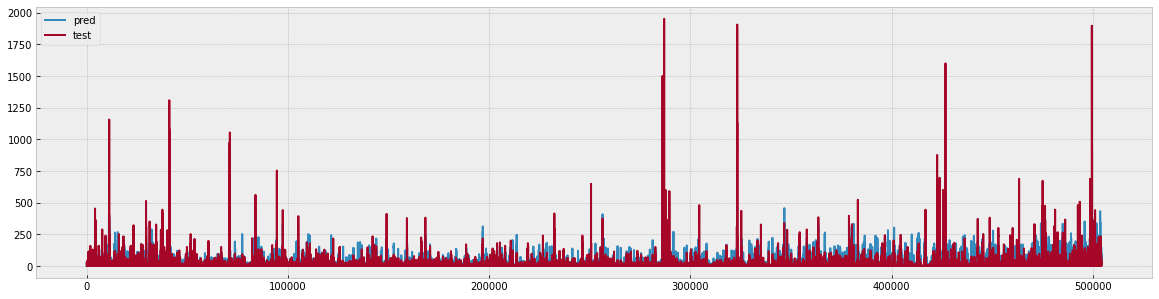

In [26]:
plt.figure(figsize=(20,5))
plt.plot(y_test.index, y_pred_lgbm2, label='pred')
plt.plot(y_test.index, 3*y_test, label='test')
plt.legend()
plt.show()

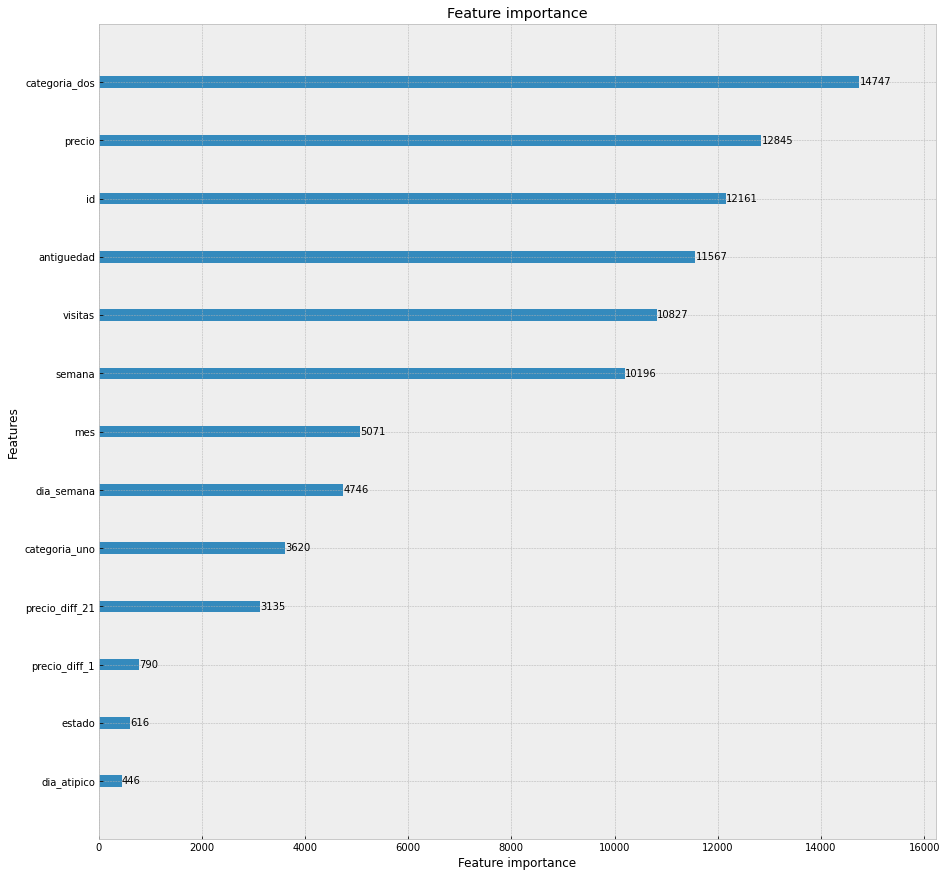

In [27]:
lgb.plot_importance(m_lgb, figsize=(15,15))

#Entrenamiento y predicción

Una vez definido el modelo en el aparatado anterior, se entrena con todo el conjunto de datos de Modelar, y se realización las predicciones con Estimar

In [28]:
#Preparar dataset Modelar y Estimar
X_train = modelar2[train_cols]
y_train = modelar2['unidades_vendidas']
X_test = estimar2[train_cols]
train_data = lgb.Dataset(X_train , label = y_train, categorical_feature=cat_feats, free_raw_data=False)
test_data = lgb.Dataset(X_test, label = y_test, categorical_feature=cat_feats, free_raw_data=False)

#Para mostrar una validación mientras entrena, no influye
fake_valid_inds = np.random.choice(X_train.index.values, 200_000, replace = False)
train_inds = np.setdiff1d(X_train.index.values, fake_valid_inds)
train_data = lgb.Dataset(X_train.loc[train_inds] , label = y_train.loc[train_inds], 
                         categorical_feature=cat_feats, free_raw_data=False)
fake_valid_data = lgb.Dataset(X_train.loc[fake_valid_inds], label = y_train.loc[fake_valid_inds],
                              categorical_feature=cat_feats,
                 free_raw_data=False)# This is a random sample, we're not gonna apply any time series train-test-split tricks here!

In [29]:
%%time
!date
#Training
m_lgb = lgb.train(params, train_data, valid_sets = [fake_valid_data], verbose_eval=10) 
#Predcit
y_pred_lgbm_estimar = m_lgb.predict(X_test)
!date

Wed Mar 17 16:17:53 UTC 2021


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[10]	valid_0's rmse: 6.42194
[20]	valid_0's rmse: 6.35725
[30]	valid_0's rmse: 6.2747
[40]	valid_0's rmse: 6.19535
[50]	valid_0's rmse: 6.10719
[60]	valid_0's rmse: 6.01095
[70]	valid_0's rmse: 5.90132
[80]	valid_0's rmse: 5.81125
[90]	valid_0's rmse: 5.73787
[100]	valid_0's rmse: 5.65813
[110]	valid_0's rmse: 5.60919
[120]	valid_0's rmse: 5.55494
[130]	valid_0's rmse: 5.51052
[140]	valid_0's rmse: 5.47845
[150]	valid_0's rmse: 5.45947
[160]	valid_0's rmse: 5.43953
[170]	valid_0's rmse: 5.42626
[180]	valid_0's rmse: 5.41331
[190]	valid_0's rmse: 5.4076
[200]	valid_0's rmse: 5.3924
[210]	valid_0's rmse: 5.37593
[220]	valid_0's rmse: 5.36394
[230]	valid_0's rmse: 5.3447
[240]	valid_0's rmse: 5.33074
[250]	valid_0's rmse: 5.31921
[260]	valid_0's rmse: 5.31086
[270]	valid_0's rmse: 5.30884
[280]	valid_0's rmse: 5.29824
[290]	valid_0's rmse: 5.29759
[300]	valid_0's rmse: 5.29507
[310]	valid_0's rmse: 5.2907
[320]	valid_0's rmse: 5.29305
[330]	valid_0's rmse: 5.28394
[340]	valid_0's rmse: 5.

In [30]:
y_pred_lgbm_estimar2 = np.round(abs(y_pred_lgbm_estimar), 0).astype('int')
y_pred_lgbm_estimar2 = 3*y_pred_lgbm_estimar2 #Se multiplica por 3 porque en FE se dividía por 3 en el dataset original
len(y_pred_lgbm_estimar2)

212841

In [31]:
y_pred_lgbm_estimar2

array([ 6, 12,  6, ..., 15, 18, 24])

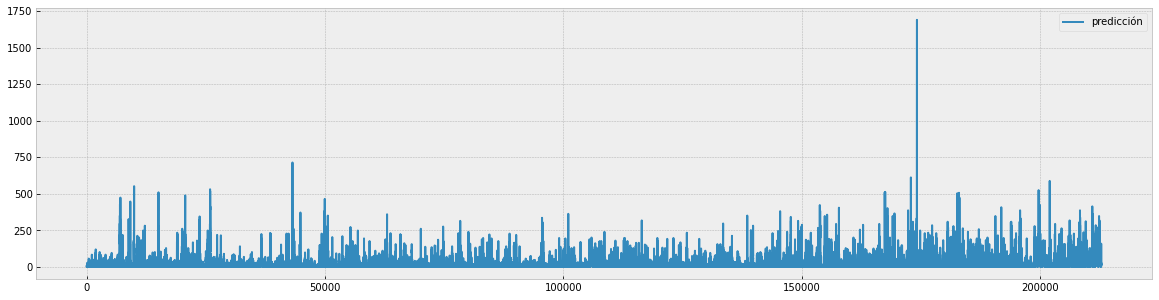

In [32]:
plt.figure(figsize=(20,5))
plt.plot(y_pred_lgbm_estimar2, label='predicción')
plt.legend()
plt.show()

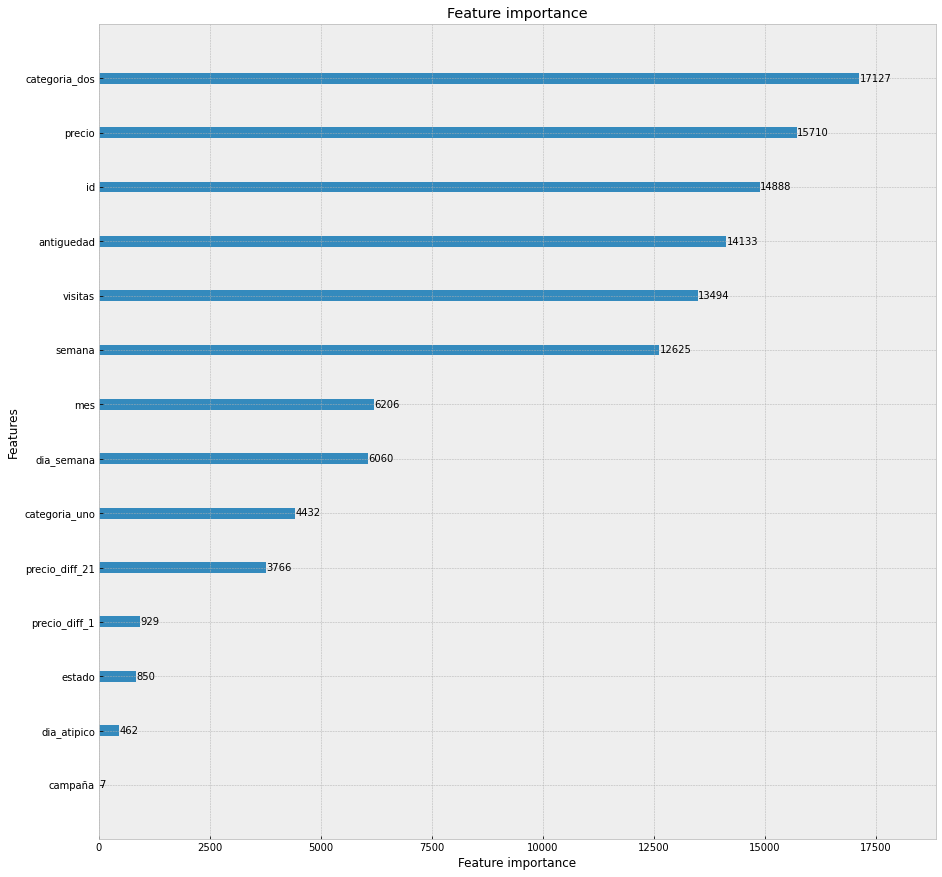

In [33]:
lgb.plot_importance(m_lgb, figsize=(15,15))

#Obtener dataset de salida

In [34]:
pred_lgbm = estimar2[['fecha','id']]
pred_lgbm['unidades_vendidas'] = y_pred_lgbm_estimar2
pred_lgbm['fecha'] = pred_lgbm['fecha'].dt.strftime('%d/%m/%Y')
pred_lgbm

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,fecha,id,unidades_vendidas
0,01/10/2016,21972,6
1,02/10/2016,21972,12
2,03/10/2016,21972,6
3,04/10/2016,21972,3
4,05/10/2016,21972,0
...,...,...,...
212836,26/12/2016,458660,21
212837,27/12/2016,458660,18
212838,28/12/2016,458660,15
212839,29/12/2016,458660,18


In [35]:
pred_lgbm.rename(columns = {'fecha': 'FECHA', 'id':'ID', 'unidades_vendidas':'UNIDADES'}, inplace = True)
pred_lgbm.to_csv('Los Forecasters.txt', sep='|', index=False, encoding='utf-8')
!ls -la | grep txt
!cp 'Los Forecasters.txt' '/gdrive/My Drive/Datathon Cajamar 2021/Data/Los Forecasters.txt' 

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


-rw-r--r-- 1 root root   4322634 Mar 17 16:24 Los Forecasters.txt


#FIN